In [122]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split

In [2]:
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)


In [3]:
class LogisticRegression(tf.Module):

  def __init__(self):
    self.built = False

  def __call__(self, x, train=True):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weights and the bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
      rand_b = tf.random.uniform(shape=[], seed=22)
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    # Compute the model output
    z = tf.add(tf.matmul(x, self.w), self.b)
    z = tf.squeeze(z, axis=1)
    if train:
      return z
    return tf.sigmoid(z)

In [4]:
data = pd.read_csv('training_data.csv', index_col=0)

In [5]:
data

,message_cur,message_prev,same_user,time_distance,label
0,2011_05_29_18_59_ActionParsnip_999,2011_05_29_18_59_gmachine_24_998,0.0,0.0,0.0
1,2011_05_29_19_00_Usuario_1000,2011_05_29_18_59_gmachine_24_998,0.0,1.0,0.0
2,2011_05_29_19_00_EvoGamer_1001,2011_05_29_18_59_gmachine_24_998,0.0,1.0,0.0
3,2011_05_29_19_00_ActionParsnip_1002,2011_05_29_18_59_gmachine_24_998,0.0,1.0,1.0
4,2011_05_29_19_00_ActionParsnip_1003,2011_05_29_18_59_gmachine_24_998,0.0,1.0,0.0
...,...,...,...,...,...
218492,2005_08_08_System_System_1248,2005_08_08_System_System_1246,1.0,0.0,0.0
218493,2005_08_08_System_System_1249,2005_08_08_System_System_1246,1.0,0.0,0.0
218494,2005_08_08_System_System_1248,2005_08_08_System_System_1247,1.0,0.0,0.0
218495,2005_08_08_System_System_1249,2005_08_08_System_System_1247,1.0,0.0,0.0


In [6]:
# Params
LEARNING_RATE = 0.01
NUM_FEATURES = 2
NUM_CLASSES = 2
TRAINING_STEPS = 1000
BATCH_SIZE = 1000
DISPLAY_STEP = 50

In [48]:
msk = data['label'] == 1
num_to_oversample = len(data) - 2*msk.sum()
df_positive_oversample = data[msk].sample(n=num_to_oversample, replace=True)
df_train_oversample = pd.concat([data, df_positive_oversample])
df_train_oversample['label'].value_counts()

0.0    193235
1.0    193235
Name: label, dtype: int64

In [103]:
#train_dataset = df_train_oversample.sample(frac=0.75)
#test_dataset = df_train_oversample.drop(train_dataset.index)
train_dataset, test_dataset = train_test_split(df_train_oversample, test_size=0.25, stratify=df_train_oversample['label'])
#X, y = data[['same_user', 'time_distance']].astype('float32'), data['label'].astype('float32')

In [104]:
test_dataset['label'].value_counts()

0.0    48309
1.0    48309
Name: label, dtype: int64

In [105]:
x_train, y_train = train_dataset[['same_user', 'time_distance']], train_dataset['label']
x_test, y_test = test_dataset[['same_user', 'time_distance']], test_dataset['label']

In [106]:
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

In [107]:
#training_data=training_data.repeat().shuffle(5000).batch(BATCH_SIZE).prefetch(1)

In [108]:
# W = tf.Variable(tf.ones([NUM_FEATURES, NUM_CLASSES]), name="weight")
#
# # Bias of shape [10], the total number of classes.
#
# b = tf.Variable(tf.zeros([NUM_CLASSES]), name="bias")

In [109]:
def predict_class(y_pred, thresh=0.5):
  # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
  return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
  # Return the proportion of matches between `y_pred` and `y`
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = predict_class(y_pred)
  check_equal = tf.cast(y_pred_class == y,tf.float32)
  acc_val = tf.reduce_mean(check_equal)
  return acc_val
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)


In [110]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)


In [111]:
log_reg = LogisticRegression()

In [112]:
# Set training parameters
epochs = 20
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate over the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Update the parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g,v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate over the testing data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = log_reg(x_batch)
    batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

  # Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  if epoch % 20 == 0:
    print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")


Epoch: 0, Training log loss: 0.584


In [113]:
test_accs

[<tf.Tensor: shape=(), dtype=float32, numpy=0.69966936>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.70755136>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.707535>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.70853984>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.70265585>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7075459>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7085181>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.70755136>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7075568>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7085181>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7075459>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7085344>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.70850724>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.70752424>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7097027>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7085181>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.707535>,
 <tf.Tensor: shape=(), dtype=float32, numpy

In [114]:
def show_confusion_matrix(y, y_classes, typ):
  # Compute the confusion matrix and normalize it
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(y.numpy(), y_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1)
  axis_labels = range(2)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title(f"Confusion matrix: {typ}")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

In [115]:
y_pred_train = log_reg(x_train, train=False)
train_classes= predict_class(y_pred_train)

In [116]:
y_train

<tf.Tensor: shape=(289852,), dtype=float32, numpy=array([1., 1., 0., ..., 1., 1., 1.], dtype=float32)>

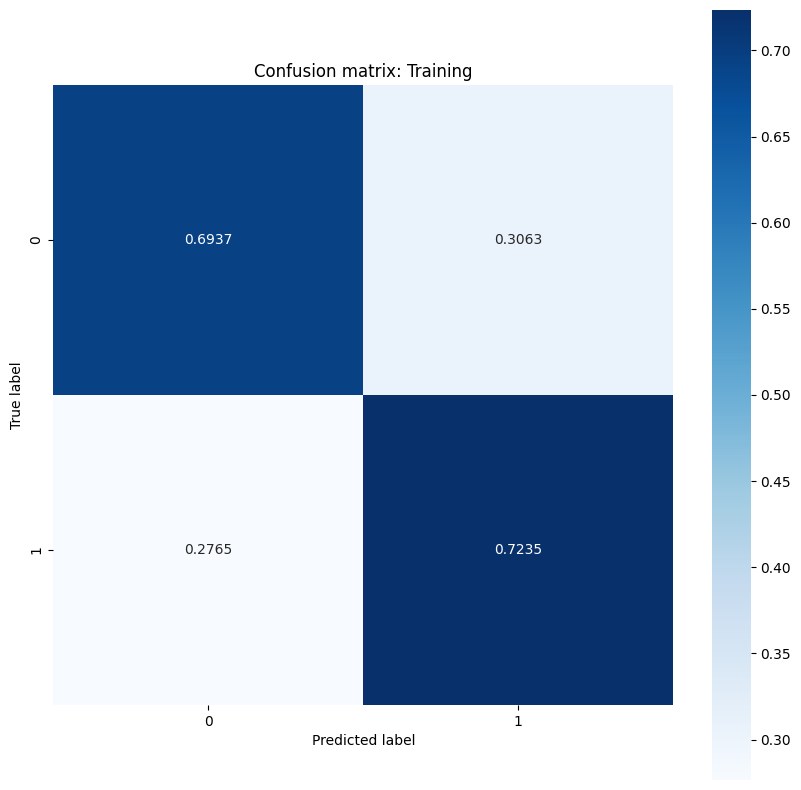

In [117]:
show_confusion_matrix(y_train, train_classes, 'Training')

In [118]:
sk_metrics.confusion_matrix(y_train.numpy(), train_classes.numpy())

array([[100530,  44396],
       [ 40076, 104850]], dtype=int64)

In [119]:
y_pred_test = log_reg(x_test, train=False)
test_classes = predict_class(y_pred_test)

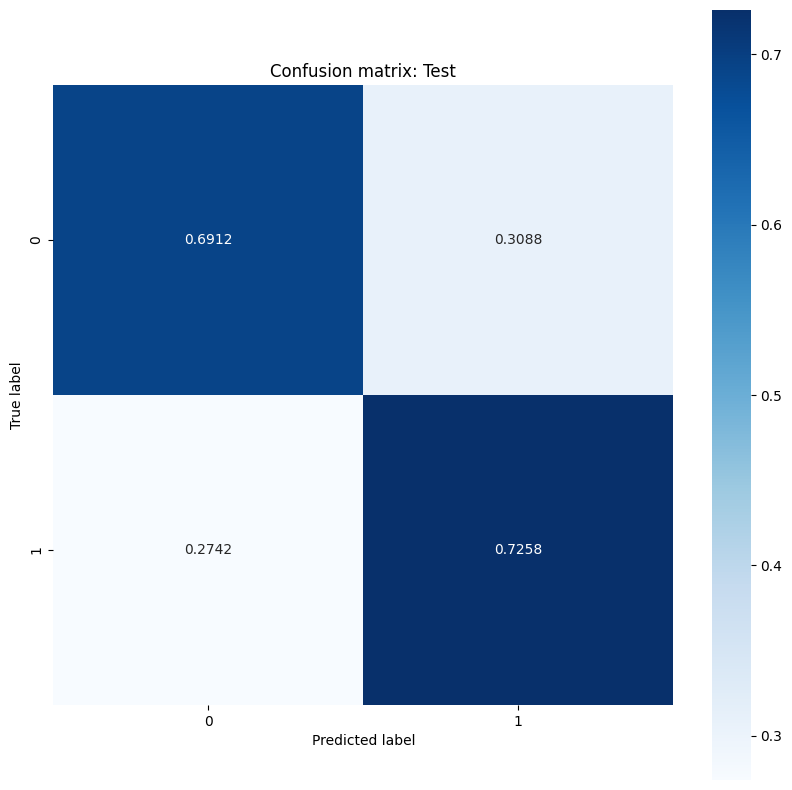

In [120]:
show_confusion_matrix(y_test, test_classes, 'Test')

In [121]:
pred_numpy = test_classes.numpy()
y_test_numpy = y_test.numpy()
sk_metrics.confusion_matrix(y_true=y_test_numpy, y_pred=pred_numpy, labels=[0, 1])

array([[33393, 14916],
       [13246, 35063]], dtype=int64)

14758.0

In [90]:
y_test.numpy() - test_classes.numpy()

array([-1., -1., -1., ...,  0.,  1.,  0.], dtype=float32)

In [70]:
test_classes

<tf.Tensor: shape=(48342,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 0., 1.], dtype=float32)>

### Random Oversampling